# TabDDPM Training and Evaluation - Clean Version

This notebook trains TabDDPM on datasets from the CTGAN paper.


## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import time
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import models
from ctgan import CTGAN, TabDDPM

# For evaluation
try:
    import sdmetrics
    from sdmetrics.reports.single_table import QualityReport
    HAS_SDMETRICS = True
    print(f"✅ SDMetrics available: {sdmetrics.__version__}")
except ImportError as e:
    print(f"⚠️ SDMetrics not installed: {e}")
    HAS_SDMETRICS = False

# Setup directories
DATA_DIR = Path('datasets')
RESULTS_DIR = Path('results')
RESULTS_DIR.mkdir(exist_ok=True)

print("✅ Setup complete!")

✅ SDMetrics available: 0.24.0
✅ Setup complete!


## 2. Load Dataset

In [2]:
def load_dataset(name, sample_size=None):
    """Load a dataset from the datasets folder."""
    
    configs = {
        'adult': {
            'file': 'adult.csv',
            'discrete': ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country', 'income']
        },
        'covertype': {
            'file': 'covertype.csv',
            'discrete': ['Cover_Type']
        },
        'intrusion': {
            'file': 'intrusion.csv',
            'discrete': ['protocol_type', 'service', 'flag', 'label']
        },
        'news': {
            'file': 'news.csv',
            'discrete': []  # Mostly continuous
        },
        'credit': {
            'file': 'creditcard.csv',  # Or credit.csv if using UCI version
            'discrete': ['Class']
        },
        'mnist12': {
            'file': 'mnist12.csv',
            'discrete': ['label']
        },
        'mnist28': {
            'file': 'mnist28.csv',
            'discrete': ['label']
        },
    }
    
    if name.lower() not in configs:
        print(f"❌ Unknown dataset: {name}")
        return None, None
    
    config = configs[name.lower()]
    filepath = DATA_DIR / config['file']
    
    if not filepath.exists():
        print(f"❌ File not found: {filepath}")
        return None, None
    
    # Load data
    df = pd.read_csv(filepath)
    
    # Sample if requested
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)
    
    discrete_columns = config['discrete']
    print(f"✅ Loaded {name} - Shape: {df.shape}, Discrete: {len(discrete_columns)}")
    
    return df, discrete_columns

In [3]:
# Configuration
DATASET_NAME = 'adult'
SAMPLE_SIZE = 10000  # Use subset for faster testing

# Load dataset
data, discrete_columns = load_dataset(DATASET_NAME, sample_size=SAMPLE_SIZE)

if data is None:
    raise Exception("Dataset not loaded! Run 01_load_datasets.ipynb first.")

print(f"\nDataset: {DATASET_NAME}")
print(f"Shape: {data.shape}")
print(f"Discrete columns ({len(discrete_columns)}): {discrete_columns}")

✅ Loaded adult - Shape: (10000, 15), Discrete: 9

Dataset: adult
Shape: (10000, 15)
Discrete columns (9): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']


In [4]:
# Split data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 8000
Test size: 2000


## 3. Train TabDDPM

In [5]:
# Initialize model with ADJUSTED configuration for better continuous data handling
model = TabDDPM(
    # Architecture
    hidden_dim=512,          # INCREASED for more capacity
    num_layers=6,            # INCREASED for more expressiveness
    time_embed_dim=256,      # INCREASED
    
    # Training - more aggressive
    epochs=500,              # MORE epochs
    batch_size=256,          # SMALLER batches for better gradients
    lr=1e-4,                 # HIGHER learning rate
    weight_decay=1e-6,       # LESS regularization
    dropout=0.05,            # LESS dropout
    
    # Diffusion parameters
    timesteps=1000,
    schedule='linear',       # Try linear instead of cosine
    
    # Sampling - add noise for diversity
    ddim_sampling=False,     # Try full DDPM sampling
    temperature=1.2,         # HIGHER temperature for more diversity
    
    verbose=True
)

In [6]:
# 1. Check data distribution
print("Data stats:")
print(train_data.describe())

# 2. Check for class imbalance
for col in discrete_columns:
    print(f"\n{col} distribution:")
    print(train_data[col].value_counts())

# 3. Verify no constant columns
for col in train_data.columns:
    if train_data[col].nunique() == 1:
        print(f"⚠️ WARNING: {col} has only 1 unique value!")

Data stats:
              age        fnlwgt  education-num  capital-gain  capital-loss  \
count  8000.00000  8.000000e+03    8000.000000   8000.000000   8000.000000   
mean     38.67825  1.896464e+05      10.110000   1105.741500     90.960000   
std      13.14910  1.082661e+05       2.530949   7533.067547    412.070973   
min      17.00000  1.376900e+04       1.000000      0.000000      0.000000   
25%      28.00000  1.170092e+05       9.000000      0.000000      0.000000   
50%      37.00000  1.779720e+05      10.000000      0.000000      0.000000   
75%      47.00000  2.358028e+05      12.000000      0.000000      0.000000   
max      90.00000  1.455435e+06      16.000000  99999.000000   3683.000000   

       hours-per-week  
count     8000.000000  
mean        40.765875  
std         11.940232  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  

workclass distribution:
workclass
Private             5923
Self-emp-

In [7]:
from sklearn.preprocessing import StandardScaler

# Normalize continuous columns before training
print("\nNormalizing continuous columns...")
continuous_columns = [col for col in train_data.columns if col not in discrete_columns]
print(f"Continuous columns to normalize: {continuous_columns}")

scaler = StandardScaler()
train_data_normalized = train_data.copy()
test_data_normalized = test_data.copy()

# Fit scaler on train data and transform both train and test
train_data_normalized[continuous_columns] = scaler.fit_transform(train_data[continuous_columns])
test_data_normalized[continuous_columns] = scaler.transform(test_data[continuous_columns])

print("✅ Data normalized")

# Train model with normalized data
print("\nTraining TabDDPM on normalized data...")
print(f"This will take ~10-15 minutes for {len(train_data_normalized)} rows...\n")

start_time = time.time()
model.fit(train_data_normalized, discrete_columns=discrete_columns)
training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time:.2f}s ({training_time/60:.2f} min)")


Normalizing continuous columns...
Continuous columns to normalize: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
✅ Data normalized

Training TabDDPM on normalized data...
This will take ~10-15 minutes for 8000 rows...


📊 Model Configuration:
  Data dimensions: 149
  Conditioning dimensions: 99
  Hidden dimensions: 512
  Number of layers: 6
  Total parameters: 5,071,765


Loss: 0.0655: 100%|██████████| 500/500 [1:12:06<00:00,  8.65s/it]


✅ Training completed in 4388.02s (73.13 min)


In [8]:
# Verify model architecture
print("\n📊 Model Architecture Check:")
print(f"  Data dimensions: {model._transformer.output_dimensions}")
print(f"  Conditioning dimensions: {model._model.cond_dim}")
print(f"  Model expects input: {model._model.input_layer[0].in_features} dims")
print(f"  Expected: {model._transformer.output_dimensions + model._model.cond_dim} dims")

# These should match!
if model._model.input_layer[0].in_features == (model._transformer.output_dimensions + model._model.cond_dim):
    print("\n✅ Architecture is correct!")
else:
    print("\n⚠️ Architecture mismatch - fix may not have been applied correctly")


📊 Model Architecture Check:
  Data dimensions: 149
  Conditioning dimensions: 99
  Model expects input: 248 dims
  Expected: 248 dims

✅ Architecture is correct!


In [9]:
# Check model learned something
print("\n🔍 Model weights check:")
for name, param in model._model.named_parameters():
    if 'weight' in name:
        print(f"{name}: mean={param.data.mean():.4f}, std={param.data.std():.4f}")
        if param.data.std() < 0.001:
            print(f"  ⚠️ Weights too small - model may have collapsed!")


🔍 Model weights check:
time_mlp.1.weight: mean=0.0013, std=0.0096
time_mlp.3.weight: mean=-0.0000, std=0.0037
input_layer.0.weight: mean=0.0003, std=0.0091
input_layer.1.weight: mean=0.8558, std=0.0542
blocks.0.mlp.0.weight: mean=-0.0001, std=0.0087
blocks.0.mlp.1.weight: mean=0.9944, std=0.0298
blocks.0.mlp.4.weight: mean=-0.0002, std=0.0078
blocks.0.mlp.5.weight: mean=0.9579, std=0.0186
blocks.1.mlp.0.weight: mean=-0.0000, std=0.0076
blocks.1.mlp.1.weight: mean=0.9982, std=0.0201
blocks.1.mlp.4.weight: mean=-0.0001, std=0.0079
blocks.1.mlp.5.weight: mean=0.9516, std=0.0177
blocks.2.mlp.0.weight: mean=-0.0000, std=0.0073
blocks.2.mlp.1.weight: mean=0.9951, std=0.0283
blocks.2.mlp.4.weight: mean=-0.0001, std=0.0081
blocks.2.mlp.5.weight: mean=0.9454, std=0.0150
blocks.3.mlp.0.weight: mean=-0.0000, std=0.0073
blocks.3.mlp.1.weight: mean=0.9978, std=0.0300
blocks.3.mlp.4.weight: mean=-0.0000, std=0.0088
blocks.3.mlp.5.weight: mean=0.9431, std=0.0151
blocks.4.mlp.0.weight: mean=-0.0001, 

## 4. Generate Synthetic Data

In [10]:
# Generate synthetic data
print("Generating synthetic data...")
start_time = time.time()

# Sample from model (will be normalized)
synthetic_data_normalized = model.sample(len(test_data))

# Denormalize the continuous columns
synthetic_data = synthetic_data_normalized.copy()
synthetic_data[continuous_columns] = scaler.inverse_transform(synthetic_data_normalized[continuous_columns])

print(f"✅ Generated and denormalized {len(synthetic_data)} samples")

# Diversity check
print("\n✅ Quick diversity check:")
for col in data.columns[:5]:
    real_unique = test_data[col].nunique()
    synth_unique = synthetic_data[col].nunique()
    
    print(f"{col}:")
    print(f"  Real: {real_unique} unique | Synth: {synth_unique} unique")
    
    if synth_unique >= real_unique * 0.7:
        print(f"  ✅ Good diversity!")
    elif synth_unique >= real_unique * 0.4:
        print(f"  ⚠️ Moderate diversity")
    else:
        print(f"  ❌ Low diversity")

sampling_time = time.time() - start_time
print(f"\n✅ Total generation time: {sampling_time:.2f}s")

Generating synthetic data...
✅ Generated and denormalized 2000 samples

✅ Quick diversity check:
age:
  Real: 67 unique | Synth: 2000 unique
  ✅ Good diversity!
workclass:
  Real: 6 unique | Synth: 7 unique
  ✅ Good diversity!
fnlwgt:
  Real: 1937 unique | Synth: 2000 unique
  ✅ Good diversity!
education:
  Real: 16 unique | Synth: 16 unique
  ✅ Good diversity!
education-num:
  Real: 16 unique | Synth: 2000 unique
  ✅ Good diversity!

✅ Total generation time: 392.88s


In [11]:
# Clean NaN values
print("\nCleaning NaN values...")
nan_before = synthetic_data.isna().sum().sum()

for col in synthetic_data.columns:
    if synthetic_data[col].isna().any():
        if synthetic_data[col].dtype == 'object':
            mode_val = synthetic_data[col].mode()[0] if len(synthetic_data[col].mode()) > 0 else 'Unknown'
            synthetic_data[col].fillna(mode_val, inplace=True)
        else:
            median_val = synthetic_data[col].median()
            if pd.isna(median_val):
                median_val = 0
            synthetic_data[col].fillna(median_val, inplace=True)

# Match dtypes
for col in synthetic_data.columns:
    try:
        synthetic_data[col] = synthetic_data[col].astype(test_data[col].dtype)
    except:
        pass

nan_after = synthetic_data.isna().sum().sum()
print(f"✅ NaN values: {nan_before} → {nan_after}")


Cleaning NaN values...
✅ NaN values: 0 → 0


Synthetic data and real data side by side:

In [30]:
print("Real data:")
display(real.head())

print("Synthetic data:")
display(synth.head())


Real data:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
217,28,Private,76714,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,55,United-States,>50K
24913,41,Private,178431,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,Taiwan,<=50K
17780,53,Private,290640,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,50,Germany,>50K
12484,31,Private,215297,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,<=50K
8890,34,Local-gov,188682,Bachelors,13,Married-spouse-absent,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K


Synthetic data:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.438929,State-gov,-1.433378,11th,-0.437839,Separated,Priv-house-serv,Own-child,White,Male,0.851332,-0.219440,0.256885,South,<=50K
1,-0.492499,Private,0.351851,11th,-0.440176,Married-AF-spouse,Other-service,Unmarried,Other,Female,-0.147514,-0.221005,2.517137,El-Salvador,<=50K
2,0.695818,Local-gov,-0.190174,12th,-1.276002,Married-civ-spouse,Adm-clerical,Unmarried,Black,Female,12.746943,-0.220689,-0.970936,Cuba,>50K
3,1.472917,Self-emp-inc,-1.285626,1st-4th,1.560851,Married-civ-spouse,Protective-serv,Own-child,White,Male,-0.149281,-0.221007,-0.068427,Guatemala,>50K
4,-1.214444,State-gov,-0.639284,5th-6th,0.769866,Married-spouse-absent,Tech-support,Husband,Other,Male,-0.148053,-0.220218,3.553103,Outlying-US(Guam-USVI-etc),<=50K


## 5. Quality Check

In [12]:
# Quick quality diagnostics
print("\n" + "="*60)
print("QUALITY DIAGNOSTICS")
print("="*60)

# Check for mode collapse
for col in data.columns[:5]:
    real_unique = test_data[col].nunique()
    synth_unique = synthetic_data[col].nunique()
    
    if pd.api.types.is_numeric_dtype(test_data[col]):
        real_mean = test_data[col].mean()
        synth_mean = synthetic_data[col].mean()
        real_std = test_data[col].std()
        synth_std = synthetic_data[col].std()
        
        print(f"\n{col}:")
        print(f"  Unique values: {real_unique} (real) vs {synth_unique} (synth)")
        print(f"  Mean: {real_mean:.2f} (real) vs {synth_mean:.2f} (synth)")
        print(f"  Std:  {real_std:.2f} (real) vs {synth_std:.2f} (synth)")
        
        # Check for collapse
        if synth_unique == 1:
            print(f"  ⚠️ WARNING: Mode collapse detected!")
        elif synth_unique < real_unique * 0.5:
            print(f"  ⚠️ Low diversity ({synth_unique}/{real_unique})")
        else:
            print(f"  ✅ Good diversity")
    else:
        print(f"\n{col}:")
        print(f"  Unique: {real_unique} (real) vs {synth_unique} (synth)")
        print(f"  Real top-3: {test_data[col].value_counts().head(3).to_dict()}")
        print(f"  Synth top-3: {synthetic_data[col].value_counts().head(3).to_dict()}")


QUALITY DIAGNOSTICS

age:
  Unique values: 67 (real) vs 74 (synth)
  Mean: 38.85 (real) vs 40.70 (synth)
  Std:  13.12 (real) vs 14.50 (synth)
  ✅ Good diversity

workclass:
  Unique: 6 (real) vs 7 (synth)
  Real top-3: {'Private': 1459, 'Self-emp-not-inc': 167, 'Local-gov': 142}
  Synth top-3: {'Private': 472, 'Self-emp-inc': 268, 'Without-pay': 261}

fnlwgt:
  Unique values: 1937 (real) vs 1996 (synth)
  Mean: 191414.40 (real) vs 227163.62 (synth)
  Std:  104094.36 (real) vs 140294.24 (synth)
  ✅ Good diversity

education:
  Unique: 16 (real) vs 16 (synth)
  Real top-3: {'HS-grad': 661, 'Some-college': 448, 'Bachelors': 362}
  Synth top-3: {'HS-grad': 160, 'Some-college': 141, 'Bachelors': 139}

education-num:
  Unique values: 16 (real) vs 16 (synth)
  Mean: 10.13 (real) vs 9.55 (synth)
  Std:  2.52 (real) vs 3.35 (synth)
  ✅ Good diversity


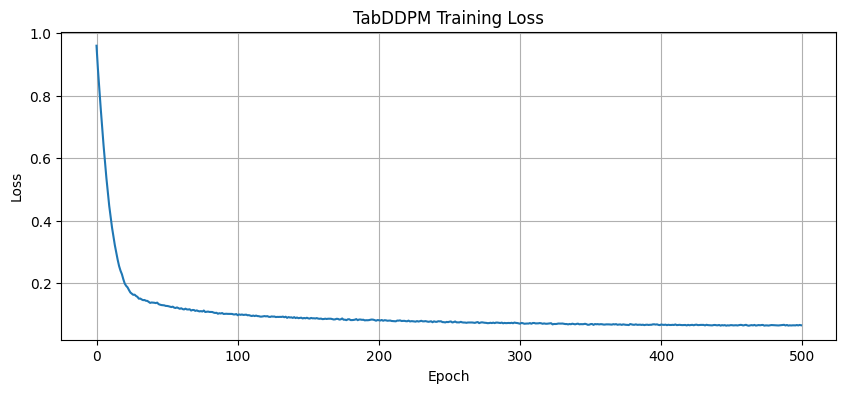

Final loss: 0.0655
✅ Low final loss - good convergence


In [13]:
# Visualize training loss
plt.figure(figsize=(10, 4))
plt.plot(model.loss_values['Epoch'], model.loss_values['Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TabDDPM Training Loss')
plt.grid(True)
plt.show()

final_loss = model.loss_values['Loss'].iloc[-1]
print(f"Final loss: {final_loss:.4f}")

if final_loss > 1.0:
    print("⚠️ High final loss - model may not have converged well")
elif final_loss < 0.1:
    print("✅ Low final loss - good convergence")
else:
    print("✅ Reasonable final loss")

## 6. Save Results

In [14]:
# Save synthetic data
synthetic_path = RESULTS_DIR / f'synthetic_{DATASET_NAME}.csv'
synthetic_data.to_csv(synthetic_path, index=False)
print(f"✅ Synthetic data saved: {synthetic_path}")

# Save model
model_path = RESULTS_DIR / f'tabddpm_{DATASET_NAME}.pkl'

payload = {
    "model_state_dict": model._model.state_dict(),
    "diffusion_params": {
        "timesteps": model.timesteps,
        "schedule": model.schedule,
        "ddim_sampling": model.ddim_sampling,
        "ddim_steps": model.ddim_steps,
    },
    "hyperparams": {
        "hidden_dim": model.hidden_dim,
        "num_layers": model.num_layers,
        "lr": model.lr,
        "batch_size": model.batch_size,
        "epochs": model.epochs,
    },
    "transformer": model._transformer,
    "data_sampler": model._data_sampler,
}

torch.save(payload, model_path)
print(f"✅ Model saved: {model_path}")

✅ Synthetic data saved: results\synthetic_adult.csv
✅ Model saved: results\tabddpm_adult.pkl


## 7. SDMetrics Evaluation (Optional)

In [15]:
if HAS_SDMETRICS:
    print("Evaluating with SDMetrics...")
    
    # Create metadata
    metadata = {}
    metadata['columns'] = {}
    
    for col in test_data.columns:
        if col in discrete_columns:
            metadata['columns'][col] = {'sdtype': 'categorical'}
        else:
            metadata['columns'][col] = {'sdtype': 'numerical'}
    
    try:
        # Generate quality report
        report = QualityReport()
        report.generate(test_data, synthetic_data, metadata)
        
        # Get overall score
        score = report.get_score()
        print(f"\n{'='*60}")
        print(f"QUALITY SCORE: {score:.4f}")
        print(f"{'='*60}")
        
        # Get detailed metrics
        details = report.get_details()
        print("\nTop 10 Metrics:")
        print(details.head(10))
        
        # Save report
        report_path = RESULTS_DIR / f'quality_report_{DATASET_NAME}.pkl'
        report.save(filepath=str(report_path))
        print(f"\n✅ Report saved: {report_path}")
        
    except Exception as e:
        print(f"⚠️ SDMetrics evaluation failed: {e}")
else:
    print("⚠️ SDMetrics not available. Install: pip install sdmetrics")

Evaluating with SDMetrics...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 335.80it/s]|
Column Shapes Score: 63.57%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:00<00:00, 119.25it/s]|
Column Pair Trends Score: 52.59%

Overall Score (Average): 58.08%


QUALITY SCORE: 0.5808
⚠️ SDMetrics evaluation failed: BaseReport.get_details() missing 1 required positional argument: 'property_name'


## 8. Compare with CTGAN

In [16]:
# Train CTGAN for comparison
print("\n" + "="*60)
print("TRAINING CTGAN FOR COMPARISON")
print("="*60)

ctgan = CTGAN(epochs=300, batch_size=500, verbose=True)

print("\nTraining CTGAN...")
start_time = time.time()
ctgan.fit(train_data, discrete_columns=discrete_columns)
ctgan_train_time = time.time() - start_time

print(f"\n✅ CTGAN training: {ctgan_train_time:.2f}s")


TRAINING CTGAN FOR COMPARISON

Training CTGAN...


Gen. (-0.34) | Discrim. (-0.17): 100%|██████████| 300/300 [24:01<00:00,  4.80s/it]


✅ CTGAN training: 1485.62s


In [17]:
# Generate with CTGAN
print("Generating with CTGAN...")
start_time = time.time()
synthetic_ctgan = ctgan.sample(len(test_data))
ctgan_sample_time = time.time() - start_time

print(f"✅ CTGAN sampling: {ctgan_sample_time:.2f}s")

Generating with CTGAN...
✅ CTGAN sampling: 0.63s


In [18]:
# Evaluate CTGAN
if HAS_SDMETRICS:
    try:
        report_ctgan = QualityReport()
        report_ctgan.generate(test_data, synthetic_ctgan, metadata)
        score_ctgan = report_ctgan.get_score()
        print(f"\nCTGAN Quality Score: {score_ctgan:.4f}")
    except:
        score_ctgan = None
else:
    score_ctgan = None

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 87.78it/s]|
Column Shapes Score: 86.15%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:03<00:00, 33.05it/s]|
Column Pair Trends Score: 82.41%

Overall Score (Average): 84.28%


CTGAN Quality Score: 0.8428


In [20]:
# Comparison summary
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)
print(f"\n{'Metric':<30} {'TabDDPM':>15} {'CTGAN':>15}")
print("-"*60)
print(f"{'Training Time (s)':<30} {training_time:>15.2f} {ctgan_train_time:>15.2f}")
print(f"{'Sampling Time (s)':<30} {sampling_time:>15.2f} {ctgan_sample_time:>15.2f}")

if HAS_SDMETRICS and score_ctgan is not None:
    print(f"{'Quality Score':<30} {score:>15.4f} {score_ctgan:>15.4f}")
    winner = "TabDDPM" if score > score_ctgan else "CTGAN"


COMPARISON SUMMARY

Metric                                 TabDDPM           CTGAN
------------------------------------------------------------
Training Time (s)                      4388.02         1485.62
Sampling Time (s)                       392.88            0.63
Quality Score                           0.5808          0.8428


# Synthetic vs Real Data Validation

These cells check whether the synthetic table is genuinely generated and not just a shuffled or copied version of the real data.

In [29]:
import pandas as pd
real = data
synth = synthetic_data_normalized

print("REAL  -> variable: 'data'                     shape:", real.shape)
print("SYNTH -> variable: 'synthetic_data_normalized' shape:", synth.shape)

_CHOSEN_REAL_NAME = "data"
_CHOSEN_SYNTH_NAME = "synthetic_data_normalized"


REAL  -> variable: 'data'                     shape: (10000, 15)
SYNTH -> variable: 'synthetic_data_normalized' shape: (2000, 15)


In [ ]:
common_cols = [c for c in real.columns if c in synth.columns]
print("Common columns:", len(common_cols), "/", len(real.columns))

if len(common_cols) < len(real.columns):
    missing = [c for c in real.columns if c not in synth.columns]
    print("Warning: the following real columns are missing in synth and will be skipped:", missing[:10], "..." if len(missing)>10 else "")

# Work on copies of the common columns
real_ = real[common_cols].copy()
synth_ = synth[common_cols].copy()

# Basic uniqueness summary (quick sanity)
uniq_summary = []
for c in common_cols:
    uniq_summary.append((c, real_[c].nunique(dropna=True), synth_[c].nunique(dropna=True),
                         pd.api.types.is_numeric_dtype(real_[c])))
uniq_df = pd.DataFrame(uniq_summary, columns=['column','real_unique','synth_unique','is_numeric'])
display(uniq_df.head(30))


Common columns: 15 / 15


,column,real_unique,synth_unique,is_numeric
0,age,72,2000,True
1,workclass,7,7,False
2,fnlwgt,8413,2000,True
3,education,16,16,False
4,education-num,16,2000,True
5,marital-status,7,7,False
6,occupation,14,14,False
7,relationship,6,6,False
8,race,5,5,False
9,sex,2,2,False


In [ ]:
# Column-distribution tests (KS for numeric, chi-square for categorical)
from scipy.stats import ks_2samp, chisquare
import numpy as np
import pandas as pd

results = []
for col in common_cols:
    rcol = real_[col].dropna()
    scol = synth_[col].dropna()
    # numeric -> KS test
    if pd.api.types.is_numeric_dtype(rcol):
        try:
            stat, p = ks_2samp(rcol, scol)
        except Exception as e:
            stat, p = np.nan, np.nan
        results.append({'column': col, 'type': 'numeric', 'statistic': float(stat), 'p_value': float(p),
                        'real_unique': int(rcol.nunique()), 'synth_unique': int(scol.nunique())})
    else:
        # categorical -> chi-square on value counts (scale expected to observed total)
        real_counts = rcol.astype(str).value_counts()
        synth_counts = scol.astype(str).value_counts()
        idx = real_counts.index.union(synth_counts.index)
        real_arr = real_counts.reindex(idx, fill_value=0).astype(float)
        synth_arr = synth_counts.reindex(idx, fill_value=0).astype(float)
        if real_arr.sum() == 0 or synth_arr.sum() == 0:
            stat, p = np.nan, np.nan
        else:
            expected = real_arr * (synth_arr.sum() / real_arr.sum())
            expected = expected + 1e-9
            try:
                stat, p = chisquare(f_obs=synth_arr, f_exp=expected)
            except Exception:
                stat, p = np.nan, np.nan
        results.append({'column': col, 'type': 'categorical', 'statistic': float(stat) if not np.isnan(stat) else np.nan,
                        'p_value': float(p) if not np.isnan(p) else np.nan,
                        'real_unique': int(real_counts.shape[0]), 'synth_unique': int(synth_counts.shape[0])})

dist_test_df = pd.DataFrame(results).set_index('column').sort_values('p_value')
# Show the most suspicious columns (lowest p-values) and also columns with identical unique counts
display(dist_test_df.head(30))


,type,statistic,p_value,real_unique,synth_unique
column,,,,,
age,numeric,1.000000,0.000000e+00,72,2000
workclass,categorical,69708.771949,0.000000e+00,7,7
fnlwgt,numeric,1.000000,0.000000e+00,8413,2000
education,categorical,10139.838445,0.000000e+00,16,16
education-num,numeric,0.993800,0.000000e+00,16,2000
marital-status,categorical,33232.828061,0.000000e+00,7,7
occupation,categorical,32263.794469,0.000000e+00,14,14
relationship,categorical,1967.692514,0.000000e+00,6,6
race,categorical,17174.312216,0.000000e+00,5,5


In [25]:
!pip install seaborn

Numeric columns used for correlation test: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Mean absolute correlation difference: 0.05577680855406167


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,0.000000,0.058019,0.043393,0.052360,0.093037,0.116138
fnlwgt,0.058019,0.000000,0.037907,0.013714,0.027496,0.040888
education-num,0.043393,0.037907,0.000000,0.118244,0.082319,0.171054
capital-gain,0.052360,0.013714,0.118244,0.000000,0.037595,0.069474
capital-loss,0.093037,0.027496,0.082319,0.037595,0.000000,0.042344
hours-per-week,0.116138,0.040888,0.171054,0.069474,0.042344,0.000000


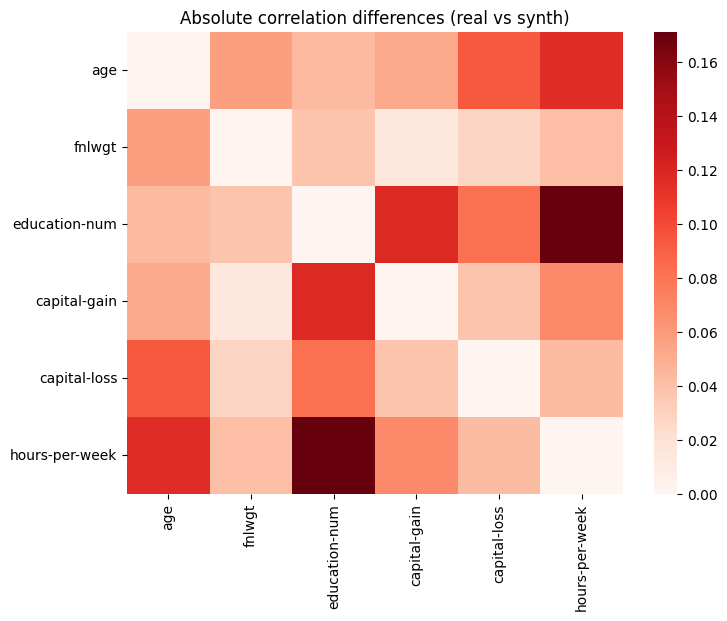

In [ ]:
# Correlation-structure comparison (numeric only)
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = [c for c in common_cols if pd.api.types.is_numeric_dtype(real_[c])]
print("Numeric columns used for correlation test:", num_cols)

if len(num_cols) >= 2:
    real_corr = real_[num_cols].corr()
    synth_corr = synth_[num_cols].corr()
    corr_diff = (real_corr - synth_corr).abs()
    print("Mean absolute correlation difference:", corr_diff.values.mean())
    display(corr_diff)
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_diff, cmap="Reds")
    plt.title("Absolute correlation differences (real vs synth)")
    plt.show()
else:
    print("Not enough numeric columns to compute correlation matrices.")


In [ ]:
#Nearest-neighbour distance test (numeric features) + exact full-row matches
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import numpy as np, pandas as pd

# Nearest-neighbour on numeric subset (standardized)
num_cols = [c for c in common_cols if pd.api.types.is_numeric_dtype(real_[c])]
if len(num_cols) == 0:
    print("No numeric columns available for NN distance test.")
else:
    R = real_[num_cols].dropna()
    S = synth_[num_cols].dropna()
    # Keep track of original indices if needed
    scaler = StandardScaler().fit(R.values)
    Rs = scaler.transform(R.values)
    Ss = scaler.transform(S.values)
    nbrs = NearestNeighbors(n_neighbors=1).fit(Rs)
    distances, indices = nbrs.kneighbors(Ss)
    distances = distances.ravel()
    print("NN distances (std. numeric space): min", distances.min(), "median", np.median(distances),
          "mean", distances.mean(), "max", distances.max())
    nn_distances = distances  # saved for later inspection

# Exact full-row matches across all common columns (string-wise equality)
rr = real_[common_cols].fillna('__nan__').astype(str).agg('||'.join, axis=1)
ss = synth_[common_cols].fillna('__nan__').astype(str).agg('||'.join, axis=1)
exact_matches_mask = ss.isin(set(rr))
exact_match_count = int(exact_matches_mask.sum())
print("Exact full-row matches found (synth rows exactly equal some real row across all compared columns):", exact_match_count)

# Show a few exact matching rows (if any)
if exact_match_count > 0:
    matched_rows = synth_.loc[exact_matches_mask]
    display(matched_rows.head(10))


NN distances (std. numeric space): min 1.6187711416534056 median 2.085888842511422 mean 2.13134798094837 max 2.8968071824430153
Exact full-row matches found (synth rows exactly equal some real row across all compared columns): 0


In [ ]:
# summary 
from IPython.display import display

print("Selected REAL variable:", _CHOSEN_REAL_NAME)
print("Selected SYNTH variable:", _CHOSEN_SYNTH_NAME)
print("\n=== Top distribution differences (by p-value) ===")
display(dist_test_df.head(10))

# Correlation summary
if 'corr_diff' in globals():
    print("\nMean absolute correlation difference (numeric cols):", corr_diff.values.mean())

# NN distances summary
if 'nn_distances' in globals():
    print("\nNearest-neighbour distances (numeric columns): min", float(nn_distances.min()),
          "mean", float(nn_distances.mean()), "median", float(np.median(nn_distances)), "max", float(nn_distances.max()))

print("\nExact full-row matches:", exact_match_count)

# heuristics
mode_collapse_numeric = dist_test_df[(dist_test_df['type']=='numeric') & (dist_test_df['real_unique']>5) & (dist_test_df['synth_unique']<=1)].index.tolist()
if mode_collapse_numeric:
    print("\nWARNING: These numeric columns look collapsed (many unique values in real but only 1 in synth):", mode_collapse_numeric)

if exact_match_count > 0:
    print("WARNING: There are exact copied rows — this indicates direct copying/leakage.")
else:
    print("No exact full-row copies detected across the compared columns.")

print("\nInterpreting results: low KS p-values / low chi-square p-values suggest distributional differences between real and synth.")
print("If p-values are ~1 for most columns and NN distances are ~0 and exact_match_count>0 then the synth is likely a row-shuffle or direct copy.")


Selected REAL variable: data
Selected SYNTH variable: synthetic_data_normalized

=== Top distribution differences (by p-value) ===


,type,statistic,p_value,real_unique,synth_unique
column,,,,,
age,numeric,1.000000,0.0,72,2000
workclass,categorical,69708.771949,0.0,7,7
fnlwgt,numeric,1.000000,0.0,8413,2000
education,categorical,10139.838445,0.0,16,16
education-num,numeric,0.993800,0.0,16,2000
marital-status,categorical,33232.828061,0.0,7,7
occupation,categorical,32263.794469,0.0,14,14
relationship,categorical,1967.692514,0.0,6,6
race,categorical,17174.312216,0.0,5,5



Mean absolute correlation difference (numeric cols): 0.05577680855406167

Nearest-neighbour distances (numeric columns): min 1.6187711416534056 mean 2.13134798094837 median 2.085888842511422 max 2.8968071824430153

Exact full-row matches: 0
No exact full-row copies detected across the compared columns.

Interpreting results: low KS p-values / low chi-square p-values suggest distributional differences between real and synth.
If p-values are ~1 for most columns and NN distances are ~0 and exact_match_count>0 then the synth is likely a row-shuffle or direct copy.
